# Packages

In [1]:
import pandas as pd  # For data manipulation and analysis
import random  # For generating random numbers
import itertools  # For efficient looping
import os  # For interacting with the operating system
import numpy as np  # For numerical operations
import scipy.stats as stats  # For statistical functions
import seaborn as sns  # For statistical data visualization
import matplotlib.pyplot as plt  # For creating static, interactive, and animated visualizations
from scipy.stats import ttest_ind, norm  # For conducting t-tests and working with normal distributions
from sklearn.metrics import mean_absolute_error, mean_squared_error  # For evaluating model performance
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.ensemble import RandomForestRegressor  # For using Random Forest regression models
from sklearn.linear_model import Lasso  # For using Lasso regression models
from sklearn.preprocessing import StandardScaler  # For feature scaling

import statsmodels.api as sm  # For statistical models and tests
import statsmodels.formula.api as smf  # For statistical models with formula interface
from linearmodels.panel import PanelOLS  # For panel data models
from tqdm import tqdm  # For adding progress bars to loops
import glob as glob

# Set the random seed for reproducibility
random.seed(123)

# Initialize the scaler
scaler = StandardScaler()

def formula_add(data):
    text = ""
    for i in data:
        text = f"{text} + {i}"
    
    return text

from scipy.special import boxcox1p
from scipy.special import erfinv


## Organización de la base

In [2]:
inf = pd.read_excel("INPUT/weo_Apr2023.xlsx")

In [3]:
info = inf[["country", "WEO_CODE", "year", "PCPI", "GGXWDG", "NGDP"]]
info["PI"] = info.groupby(["WEO_CODE"])["PCPI"].pct_change()*100
info["DEBT_GDP"] = (info["GGXWDG"]/info["NGDP"])*100
inf10 = info[info.year==2020][["WEO_CODE", "PCPI"]]; inf10.columns = ["WEO_CODE", "PCPI_10"]
info = info.merge(inf10, "left", "WEO_CODE")
info["PCPI_B10"] = (info["PCPI"]/info["PCPI_10"])*100
info["ACTUAL_PIB10"] = info.groupby(["WEO_CODE"])["PCPI_B10"].pct_change()
info = info[['country', 'WEO_CODE', 'year', 'PI','DEBT_GDP', 'PCPI_B10']]
info.columns = ["COUNTRY_NAME", "WEO_CODE", "DATE", "PI", "DEBT_GDP", "PI_I"]
info = info[info.DATE<=2022]

inff = pd.read_excel("INPUT/WEOhistorical.xlsx", sheet_name="pcpi_pch_arranged")
inff = inff[['WEO_CODE', 'DATE', 'PI_ST5', 'PI_ST4', 'PI_ST3', 'PI_ST2', 'PI_ST1']]
infr = info.merge(inff, "left", ["WEO_CODE", "DATE"]).dropna()

qsi = infr.PI.quantile(0.95)
qii = infr.PI.quantile(0.05)

# qsd = infr.DEBT_GDP.quantile(0.95)
# qid = infr.DEBT_GDP.quantile(0.05)

infr = infr[(infr.PI<qsi) & (infr.PI>qii)]
# infr = infr[(infr.DEBT_GDP<qsd) & (infr.DEBT_GDP>qid)]

for i in ['PI_ST5', 'PI_ST4', 'PI_ST3', 'PI_ST2', 'PI_ST1']:
    infr[f"PCT_{i}"] = infr[i].copy()
    infr[i] = np.log(1+np.abs(infr["PI"]-infr[i])) # -> LOG 1 + ABS

    # infr[i] = np.log((infr["PI"]-infr[i])**2) # -> OK, LOG CUADRATICA
    # infr[i] = np.log(1+(infr["PI"]-infr[i])**2) # -> OK, LOG 1 + CUADRATICA
    # infr[i] = np.sqrt(np.abs(infr["PI"] - infr[i])) # -> RAIZ CUADRAD  ABS 

    # infr[i] = np.sqrt(1 + np.abs(infr["PI"] - infr[i])) # -> RAIZ CUADRAD 1 + ABS
    # infr[i] = 1 / (1 + np.exp(-(np.abs(infr["PI"] - infr[i])))) # -> OK SIGMOIDE
    # infr[i] = boxcox1p(infr["PI"] - infr[i], 0.5) # -> OK BOX-COX
    # infr[i] = np.arcsinh(np.abs(infr["PI"] - infr[i])) # -> OK arcseno
    # infr[i] = np.tanh(np.abs(infr["PI"] - infr[i])) # - VTANGENTE ARC

    # infr = infr.merge(infr.groupby('WEO_CODE')[i].mean().reset_index().rename(columns = {i : f"D_{i}"}), "left", "WEO_CODE")
    # infr[i] = infr[i]/infr[f"D_{i}"]

    
    


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_18184\3907555315.py:2: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  info["PI"] = info.groupby(["WEO_CODE"])["PCPI"].pct_change()*100
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_18184\3907555315.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info["PI"] = info.groupby(["WEO_CODE"])["PCPI"].pct_change()*100
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_18184\3907555315.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [4]:
# infr[(infr.PCT_PI_ST1<0) | (infr.PCT_PI_ST2<0) | (infr.PCT_PI_ST3<0) | (infr.PCT_PI_ST4<0) | (infr.PCT_PI_ST5<0) | (infr.PI<0)]
# infr[infr.COUNTRY_NAME=="Colombia"]
# infr[(infr.COUNTRY_NAME=="Colombia") & (infr.DATE==2022)]
# np.log(0.00000000001+np.abs(10.184313-2.644))

# def calculate_forecast_index(row, forecast_col):
#     previous_year_index = infr[(infr['WEO_CODE'] == row['WEO_CODE']) & (infr['DATE'] == row['DATE'] - 1)]['PI_I']
#     if not previous_year_index.empty:
#         return previous_year_index.values[0] * (1 + row[forecast_col] / 100)
#     else:
#         return np.nan

# for i in ['PI_ST5', 'PI_ST4', 'PI_ST3', 'PI_ST2', 'PI_ST1']:
#     infr[i] = infr.apply(lambda row: calculate_forecast_index(row, i), axis=1)

# for i in ['PI_ST5', 'PI_ST4', 'PI_ST3', 'PI_ST2', 'PI_ST1']:
#     infr[i] = (infr[i]-infr["PI_I"])/infr["PI_I"]


    # K = 1
    # K = np.log(1+np.abs(infr["PI"]-infr[i])).mean()
    # print(K)
    # infr[i] = np.log(1+np.abs(infr["PI"]-infr[i]))
    # infr[i]

# infr[infr['PI_ST5'].isna()]
# infr[infr['PI_ST5']==0]
# infr = infr.dropna()

# XY = infr.set_index(["WEO_CODE", "DATE"]).dropna()

# XINF = ['PI_ST5', 'PI_ST4', 'PI_ST3', 'PI_ST2', 'PI_ST1']
# XINF = ['PI_ST5', 'PI_ST4', 'PI_ST3', 'PI_ST2']
# XINF = ['PI_ST5', 'PI_ST4', 'PI_ST3']
# XINF = ['PI_ST5', 'PI_ST4'] #CON ESTA ES
# XINF = ['PI_ST5']

# formula = f"PI ~  {formula_add(XINF)} + EntityEffects + TimeEffects"
# formula = f"PI ~  {formula_add(XINF)}"
# formula = f"PI ~  PI_ST4 "
# modelols = PanelOLS.from_formula(formula, data=XY)
# modelols = modelols.fit()
# modelols.summary

# XY["A"] = modelols.predict()
# XY["PI"].plot(kind = "hist")
# XY["A"].plot(kind = "hist")

# Primer nivel

Dep. Variable:,PI,R-squared:,0.2629
Estimator:,PanelOLS,R-squared (Between):,0.8005
No. Observations:,3916,R-squared (Within):,0.3016
Date:,"Mon, Aug 12 2024",R-squared (Overall):,0.7023
Time:,15:11:23,Log-likelihood,-8623.4
Cov. Estimator:,Unadjusted,,
,,F-statistic:,146.67
Entities:,180,P-value,0.0000
Avg Obs:,21.756,Distribution:,"F(9,3701)"
Min Obs:,1.0000,,
Max Obs:,27.000,F-statistic (robust):,146.67


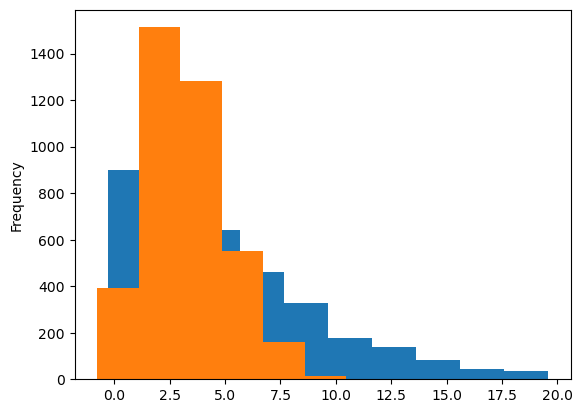

In [6]:
# dfislac = pd.read_excel("INPUT/FISLAC_update.xlsx")
# totaldfr = pd.read_csv("INPUT/total_dataset_20230911.csv")

# D       = ["DEBT_GDP"] #DEUDA
C_DEUDA = ["DEBT_AFFORTABILITY", "PRIM_BAL_GDP", "ER_DEP", "ER_DEP_VOL", "GDP_R_GR", "DOM_DEBT"] #CONTROLES DE LA DEUDA
C_INS   = ['WGI_GOV_IND', 'DEMOCRACY', 'TRADE_OPEN'] #OTROS CONTROLES: INSTITUCIONALES + APERTURA
IDS     = ["WEO_CODE", "ISO3", "DATE", "REGION", "LAC1", "LAC2"]

dfislac2 = dfislac[IDS+C_DEUDA+C_INS]

### Profundidad financiera
deepf = pd.read_excel("INPUT/Data_profundidad_financiera.xlsx")
deepf = deepf[["WEO_CODE", "DATE", "ka_open", "pnfs_nfs", "dom_debt_sh"]]
deepf["pnfs_nfs"] = deepf["pnfs_nfs"]/100
deepf.columns = [i.upper() for i in deepf.columns]

## restricción financiera
bank = pd.read_excel("INPUT/BANK_OWNERSHIP.xlsx")
bank = bank[["ISO", "year", "FOR1_DB"]]
bank = bank.rename(columns = {"ISO":"ISO3", "year": "DATE"})

dff = infr.merge(dfislac2, "left", ["WEO_CODE", "DATE"])

### Creación de covariables
D = ["DEBT_GDP"]
C_DEUDA = ["DEBT_AFFORTABILITY", "PRIM_BAL_GDP", "ER_DEP", "ER_DEP_VOL"] 
C_INS   = ['WGI_GOV_IND', 'DEMOCRACY', 'TRADE_OPEN'] 

C_DEUDA_L = [f"{i}_l1" for i in C_DEUDA]

for i,e in zip(C_DEUDA, C_DEUDA_L):
    dff[e] = dff.groupby("WEO_CODE")[i].shift(1)


# XINF = ['PI_ST5', 'PI_ST4', 'PI_ST3', 'PI_ST2', 'PI_ST1'] #128.
# XINF = ['PI_ST5', 'PI_ST4', 'PI_ST3', 'PI_ST2'] #139.44
# XINF = ['PI_ST5', 'PI_ST4', 'PI_ST3'] #145
XINF = ['PI_ST5', 'PI_ST4'] #CON ESTA ES, 146
# XINF = ['PI_ST5'] #144

dff = dff[["WEO_CODE", "ISO3", "DATE", "REGION", "LAC1", "LAC2"] + D + ["PI"] + 
          ['PI_ST5', 'PI_ST4', 'PI_ST3', 'PI_ST2', 'PI_ST1'] +
          ['PCT_PI_ST5', 'PCT_PI_ST4', 'PCT_PI_ST3', 'PCT_PI_ST2', 'PCT_PI_ST1'] +
          C_DEUDA + C_INS + C_DEUDA_L ].dropna()


XY = dff.set_index(["WEO_CODE", "DATE"]).dropna()

dff = dff.merge(deepf, "left", ["WEO_CODE", "DATE"])
dff = dff.merge(bank, "left", ["ISO3", "DATE"])

formula = f"PI ~  {formula_add(XINF)} + {formula_add(C_DEUDA_L)} +  {formula_add(C_INS)} + EntityEffects + TimeEffects"
modelols = PanelOLS.from_formula(formula, data=XY)
modelols = modelols.fit()

dff["PI_IV"] = modelols.predict().values
dff = dff.rename(columns = {"PI": "PIA"})

# dff.to_excel("finaldb.xlsx", index = False)
XY["A"] = modelols.predict()
XY["PI"].plot(kind = "hist")
XY["A"].plot(kind = "hist")

modelols.summary


# Segundo nivel: Principal

### Paramétros

In [7]:
import os
results = "RESULTS"
os.makedirs(results, exist_ok=True)

# INF = "PIA"
INF = "PI_IV"

os.makedirs(f'{results}/{INF}', exist_ok=True)

dff["PI"] = dff[INF].copy()


# dff[["PIA", "PI_IV", "PI"]]

D = ["DEBT_GDP"]
dfix = dff.copy()[["WEO_CODE", "ISO3", "DATE", "REGION", "LAC1", "LAC2"] + D + ["PI"] + C_DEUDA + C_INS + C_DEUDA_L ].dropna()
dfix = dfix[dfix.DEBT_GDP<=200]
dfix = dfix[["WEO_CODE", "DATE"]]
dfr = dfix.merge(dff, "left", ["WEO_CODE", "DATE"])
dfr["DEBT_GDP"] = dfr["DEBT_GDP"]/100
dfr["PI"] = dfr["PI"]/100

dfr["DH"] = dfr["DEBT_GDP"].apply(lambda x: 1 if x>=0.64 else 0)
dfr["DH_PI"] = dfr["DH"]*dfr["PI"]

In [36]:
# dff.DEBT_GDP.plot(kind = "hist")
# dff.DEBT_GDP.quantile(0.95)
# dff.PI.quantile(0.95)
# dff[dff.DEBT_GDP<=2].to_excel("finaldb.xlsx", index = False)

# model = smf.quantreg(formula, dfrr)
# result = model.fit(q=0.05)
# result.summary2()

## Baseline: estimación

### Tabla

In [37]:
# CONTROLES = ["0_NOCONTROL", "1_DEUCONTROL", "2_ALLCONTROL"]
CONTROLES = ["2_ALLCONTROL"]

DEPENDIENTE   =  "DEBT_GDP" 
INDEPENDIENTE =  "PI"

for CONTROL in CONTROLES:

    result_df = pd.DataFrame()
    rango_pct = np.arange(0.01, 1, 0.01)

    for i in tqdm(rango_pct):

        qv = dfr[DEPENDIENTE].quantile(i)
        qs = i

        if CONTROL == '0_NOCONTROL':
            formula = f'{DEPENDIENTE} ~ {INDEPENDIENTE} + PI'
        
        elif  CONTROL == '1_DEUCONTROL':
            formula = f'{DEPENDIENTE} ~ {INDEPENDIENTE} + {formula_add(C_DEUDA_L)} + PI'
        
        elif  CONTROL == '2_ALLCONTROL':
            formula = f'{DEPENDIENTE} ~ {INDEPENDIENTE} {formula_add(C_DEUDA_L)}  {formula_add(C_INS)}'

        # dfr["DEBT_GDP"] = np.log(1+dfr["DEBT_GDP"])
        # dfr["PI"] = dfr["PI"]*100
            
        model = smf.quantreg(formula, dfr)
        result = model.fit(q=qs)

        slope = result.params[INDEPENDIENTE]
        pvalue = result.pvalues[INDEPENDIENTE]

        lower, upper = result.conf_int().loc[INDEPENDIENTE, 0], result.conf_int().loc[INDEPENDIENTE, 1]


        new_row_df = pd.DataFrame({
            'Quantile': [qs],
            'Quantile_value': [qv],
            'Slope': [slope],
            'Lower': [lower],
            'Upper': [upper],
            "p-value": [pvalue],
            "R-squared": [result.prsquared]
        })

        # Usas pd.concat() para añadir la nueva fila al DataFrame existente:
        result_df = pd.concat([result_df, new_row_df], ignore_index=True)
        
    result_df["Quantile"] = round(result_df["Quantile"], 2)
    # result_df.to_excel(f'{results}/{INF}/{CONTROL}.xlsx', index = False)
    result_df.to_excel(f'{results}/{INF}/{CONTROL}_DD.xlsx', index = False)

# result_df.to_excel(f'{results}/{INF}/{CONTROL}_DD.xlsx', index = False)


 23%|██▎       | 23/99 [00:02<00:07, 10.34it/s]c:\Users\USUARIO\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 29%|██▉       | 29/99 [00:03<00:08,  8.25it/s]c:\Users\USUARIO\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 39%|███▉      | 39/99 [00:04<00:06,  9.77it/s]c:\Users\USUARIO\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 91%|█████████ | 90/99 [00:10<00:00,  9.09it/s]c:\Users\USUARIO\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: 

### Gráficas

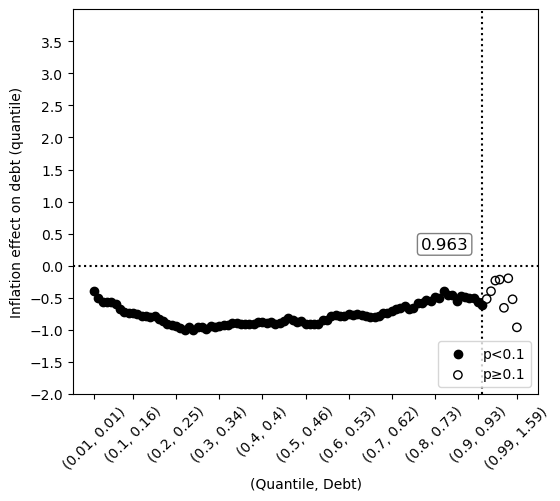

In [34]:
# modelos = glob.glob(f'{results}/{INF}/*.xlsx')
modelos = [f'{results}/{INF}/{CONTROL}_DD.xlsx']
for i in modelos:

    result_df = pd.read_excel(i)
    ###################################################################################################################################################################
    plt.figure(figsize=(6, 5)) ###TAMAÑO
    # plt.figure(figsize=(8, 6))
    ############################################################################################
    #SCATTER PLOT
    bins = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 1]
    labels = [90, 70, 60, 40, 30, 20]
    result_df['Slope'] = result_df['Slope']
    result_df['pc'] = pd.cut(result_df['p-value'], bins=bins, labels=labels, include_lowest=True, right=False)

    result_df["significative"] = result_df["p-value"].apply(lambda x: 1 if x<0.1 else 0)
    significant = result_df[result_df['significative'] == 1]
    not_significant = result_df[result_df['significative'] == 0]
    # plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label='p<0.1', s = significant["pc"])
    # plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', facecolors='none', edgecolors='black', label='p≥0.1', s=not_significant["pc"])
    plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label='p<0.1')
    plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', facecolors='none', edgecolors='black', label='p≥0.1')

    ############################################################################################
    # LINEAS DE THRESHOLD
    # Add a vertical line at x = threshold.Quantile with a label
    plt.axhline(y=0, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0


    threshold_v = result_df[(result_df["significative"]==1) & (result_df["Slope"]<0)].iloc[-1]
    threshold = {'Quantile': threshold_v.Quantile, 'Quantile_value': threshold_v.Quantile_value}
    plt.axvline(x=threshold['Quantile'], color='black', linestyle='dotted')


    try:
        threshold_v2 = result_df[(result_df["significative"]==1) & (result_df["Slope"]>0)].iloc[0]
        threshold2 = {'Quantile': threshold_v2.Quantile, 'Quantile_value': threshold_v2.Quantile_value}
        plt.axvline(x=threshold2['Quantile'], color='black', linestyle='dotted')
    
    except:
        None




    ############################################################################################
    #LABELS/LEYENDAS 
    plt.xlabel(f'(Quantile, Debt)') ###LEYENDA
    # plt.xlabel(f'Quantile')
    plt.ylabel(f'Inflation effect on debt (quantile)')


    plt.annotate(
        f"{threshold['Quantile_value']:.3f}",
        # f"q {threshold['Quantile']}, Debt: {threshold['Quantile_value']:.3f}",
        xy=(threshold['Quantile'], 0),  # Position of the label
        xytext=(-10, 10),  # Offset for label placement (adjust as needed)
        textcoords='offset points',
        ha='right',  # Horizontal alignment of the label
        va='bottom',  # Vertical alignment of the label
        color='black',  # Text color
        fontsize=12,  # Text font size
        bbox=dict(boxstyle='round,pad=0.2', edgecolor='black', facecolor='white')  # Label background
        )
    
    # try:

    #     plt.annotate(
    #         f"{threshold2['Quantile_value']:.3f}",
    #         # f"q {threshold['Quantile']}, Debt: {threshold['Quantile_value']:.3f}",
    #         xy=(threshold2['Quantile'], 0),  # Position of the label
    #         xytext=(45, -30),  # Offset for label placement (adjust as needed)
    #         textcoords='offset points',
    #         ha='right',  # Horizontal alignment of the label
    #         va='bottom',  # Vertical alignment of the label
    #         color='black',  # Text color
    #         fontsize=12,  # Text font size
    #         bbox=dict(boxstyle='round,pad=0.2', edgecolor='black', facecolor='white')  # Label background
    #         )
        
    #     

    # except:
    #     None


    plt.legend(scatterpoints=1, loc='lower right')

    ############################################################################################
    ymax = round(result_df["Slope"].max() + result_df["Slope"].std()/2,1)
    ymin = round(result_df["Slope"].min() - result_df["Slope"].std()/2,1)

    ymax, ymin = 4, -2
    # ymax, ymin = 0.7, -0.2
    plt.ylim(ymin, ymax)
    plt.yticks(np.arange(ymin, ymax, 0.5))  # Set custom y-axis ticks with 0.05 unit jumps

    # qsticks= [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]
    qsticks= [0.01, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.99]
    df_tick = result_df[result_df["Quantile"].isin(qsticks)]
    custom_xticks = [(round(qs,2), round(qv,2)) for qs, qv in zip(df_tick['Quantile'], df_tick['Quantile_value'])]
    
    # plt.xticks(np.arange(0, 1.05, 0.05), custom_xticks,rotation=45)  # Include rotation for better visibility
    plt.xticks(qsticks, custom_xticks,rotation=45)  # Include rotation for better visibility


    # plt.scatter(result_df['Quantile'], result_df['freq']) #PONLE ACÁ EL EJE Y DEL LADO DERECHO

    # plt.legend()
    # plt.grid(True)
    # plt.savefig(i.replace(".xlsx", ".jpeg"), dpi = 300, bbox_inches='tight')
    plt.savefig(i.replace(".xlsx", ".svg"), dpi = 300, bbox_inches='tight')
    # plt.savefig("grafico.svg", format='svg')
    plt.grid(False)
    plt.show()
    

## Placebos: robustez

### Estimación

In [220]:
# CONTROLES = ["0_NOCONTROL", "1_DEUCONTROL", "2_ALLCONTROL"]
CONTROLES = ["2_ALLCONTROL"]

np.random.seed(1820) 

DEPENDIENTE   =  "DEBT_GDP" 
INDEPENDIENTE =  "PI"

# for quantil in [0.05, 0.1, 0.25, 0.5, 0.75, 0.91, 0.95]:
for quantil in [0.91]:
# for quantil in [0.05, 0.1, 0.25]:

    result_df = pd.DataFrame()
    # rango_pct = np.arange(0.01, 1, 0.01)

    for i in tqdm(range(0,10)):

        dfrr  = dfr.copy()

        qv = dfrr[DEPENDIENTE].quantile(quantil)
        qs = quantil

        formula = f'{DEPENDIENTE} ~ {INDEPENDIENTE} {formula_add(C_DEUDA_L)}  {formula_add(C_INS)}'

        print(formula)

        if i!=0:

            dfrr[INDEPENDIENTE] = dfrr[INDEPENDIENTE].sample(frac=1).reset_index(drop=True)

        else:
            None
            
        model = smf.quantreg(formula, dfrr)
        result = model.fit(q=qs)

        slope = result.params[INDEPENDIENTE]
        pvalue = result.pvalues[INDEPENDIENTE]

        lower, upper = result.conf_int().loc[INDEPENDIENTE, 0], result.conf_int().loc[INDEPENDIENTE, 1]


        new_row_df = pd.DataFrame({
            'Quantile': [qs],
            'Quantile_value': [qv],
            'Slope': [slope],
            'Lower': [lower],
            'Upper': [upper],
            "p-value": [pvalue],
            "R-squared": [result.prsquared]
        })

        # Usas pd.concat() para añadir la nueva fila al DataFrame existente:
        result_df = pd.concat([result_df, new_row_df], ignore_index=True)
        
    result_df["Quantile"] = round(result_df["Quantile"], 2)
    result_df.to_excel(f'{results}/{INF}/ROBUST_RANDINF_{quantil}.xlsx', index = False)

  0%|          | 0/10 [00:00<?, ?it/s]

DEBT_GDP ~ PI  + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + ER_DEP_l1 + ER_DEP_VOL_l1   + WGI_GOV_IND + DEMOCRACY + TRADE_OPEN


c:\Users\USUARIO\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 30%|███       | 3/10 [00:00<00:01,  6.35it/s]

DEBT_GDP ~ PI  + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + ER_DEP_l1 + ER_DEP_VOL_l1   + WGI_GOV_IND + DEMOCRACY + TRADE_OPEN
DEBT_GDP ~ PI  + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + ER_DEP_l1 + ER_DEP_VOL_l1   + WGI_GOV_IND + DEMOCRACY + TRADE_OPEN
DEBT_GDP ~ PI  + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + ER_DEP_l1 + ER_DEP_VOL_l1   + WGI_GOV_IND + DEMOCRACY + TRADE_OPEN
DEBT_GDP ~ PI  + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + ER_DEP_l1 + ER_DEP_VOL_l1   + WGI_GOV_IND + DEMOCRACY + TRADE_OPEN


 70%|███████   | 7/10 [00:00<00:00,  9.73it/s]

DEBT_GDP ~ PI  + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + ER_DEP_l1 + ER_DEP_VOL_l1   + WGI_GOV_IND + DEMOCRACY + TRADE_OPEN
DEBT_GDP ~ PI  + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + ER_DEP_l1 + ER_DEP_VOL_l1   + WGI_GOV_IND + DEMOCRACY + TRADE_OPEN
DEBT_GDP ~ PI  + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + ER_DEP_l1 + ER_DEP_VOL_l1   + WGI_GOV_IND + DEMOCRACY + TRADE_OPEN


100%|██████████| 10/10 [00:01<00:00,  8.00it/s]

DEBT_GDP ~ PI  + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + ER_DEP_l1 + ER_DEP_VOL_l1   + WGI_GOV_IND + DEMOCRACY + TRADE_OPEN
DEBT_GDP ~ PI  + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + ER_DEP_l1 + ER_DEP_VOL_l1   + WGI_GOV_IND + DEMOCRACY + TRADE_OPEN


### Gráficas

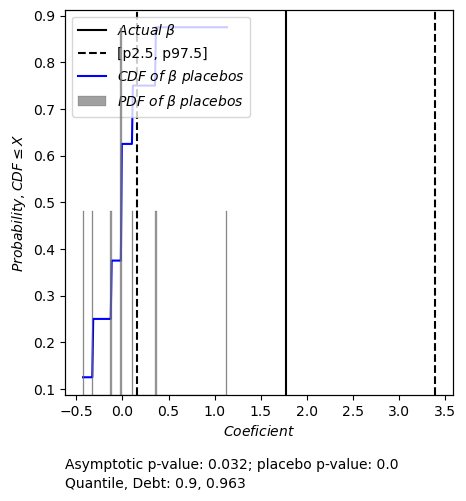

In [221]:
# for quantil in [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]:
for quantil in [0.91]:

    dfqq = pd.read_excel(f'RESULTS/PI_IV/ROBUST_RANDINF_{quantil}.xlsx')

    dfg = dfqq.iloc[2:]
    placebos = pd.DataFrame(zip(dfg.Quantile, dfg.Slope), columns = ["treshold", "XT"])    

    min_coef = round(placebos.XT.min(),3)
    max_coef = round(placebos.XT.max(),3)

    results2 = []
    NPLA = placebos.shape[0]
    for i in np.arange(min_coef, max_coef, 0.01):
        prob = (placebos["XT"] <= i).sum() / NPLA
        results2.append({"coef": i, "P<=coef": prob})
    placebos_cdf = pd.DataFrame(results2)

    truec = dfqq.iloc[0].Slope
    true_is = dfqq.iloc[0].Upper
    true_ii = dfqq.iloc[0].Lower

    valor = dfqq.iloc[0].Quantile_value

    pvalue_ols = round(dfqq.iloc[0]["p-value"],3)
    if truec<0:
        pvalue_placebo = round(1 - ((placebos["XT"] >= truec).sum() / NPLA),3)
    else:
        pvalue_placebo = round(1 - ((placebos["XT"] <= truec).sum() / NPLA),3)


    # fig, ax1 = plt.subplots(figsize=(10, 5))  # Cambia los valores según necesites
    fig, ax1 = plt.subplots(figsize=(5, 5))  # Cambia los valores según necesites
    ax2 = ax1.twinx()

    # Primero dibujar las líneas verticales
    ax1.axvline(x=truec, color='black', linestyle='-', label=r"$Actual \ \beta$")
    ax1.axvline(x=true_ii, color='black', linestyle='--', label="[p2.5, p97.5]")
    ax1.axvline(x=true_is, color='black', linestyle='--')

    # Luego dibujar la línea CDF
    ax1.plot(placebos_cdf['coef'], placebos_cdf['P<=coef'], label=r"$CDF \ of \ \beta  \ placebos$", color="blue")

    # Finalmente dibujar el histograma
    sns.histplot(placebos['XT'], ax=ax2, label=r"$PDF \ of \ \beta  \ placebos$", color="gray", bins=100, stat="probability")
    ax2.set_yticks([])  # Elimina los ticks del eje Y derecho
    ax2.set_yticklabels([])  # Elimina las etiquetas de los ticks del eje Y derecho
    ax2.set_ylabel('')  # Asegura que no haya etiqueta en el eje Y derecho

    # Extraer la información de la leyenda de cada eje
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    # Combina la información de las leyendas de ambos ejes
    ax1.legend(handles=handles1 + handles2, labels=labels1 + labels2, loc='upper left')

    # Etiquetas y texto
    ax1.set_xlabel(r'$Coeficient$')  # Etiqueta del eje X
    ax1.set_ylabel(r'$Probability, CDF \leq X$')  # Etiqueta del eje Y para la CDF

    # plt.xlim()

    # Texto en la figura
    plt.text(0, -0.2, f'Asymptotic p-value: {pvalue_ols}; placebo p-value: {pvalue_placebo}', transform=ax1.transAxes, ha='left', va='bottom')
    # plt.text(0, -0.25, f'Quantile, Debt: {quantil}, {round(valor,3)}', transform=ax1.transAxes, ha='left', va='bottom')
    plt.text(0, -0.25, f'Quantile, Debt: {0.9}, {round(valor,3)}', transform=ax1.transAxes, ha='left', va='bottom')

    plt.savefig(f'{results}/{INF}/ROBUST_RANDINF_{quantil}.jpeg', dpi=100, bbox_inches='tight')

    plt.show()


# Mecanismos

### Independencia del Banco Central

In [8]:
inftarg = pd.read_excel("INPUT/Inflation_Targeting.xlsx", sheet_name = "COMPILATION")
inftarg = inftarg[["ISO3","DATE", "absolute_target_deviation", "inside_range"]]
inftarg.columns = ["ISO3","DATE", "TD", "IR"]
dfit = pd.merge(dfr, inftarg, "left", ["ISO3", "DATE"])

inftargind = pd.read_excel("INPUT/Inflation_Targeting.xlsx", sheet_name = "INDEPENDENCY DATA")
inftargind = inftargind[["ISO3","DATE", 
                      "independence", "independence_ceo", "price_est_obj", "final_dec_monpol", "lending_government_restriction"]]

dfit = pd.merge(dfit, inftargind, "left", ["ISO3", "DATE"])

# inftarg.columns = ["ISO3","DATE", "TD", "IR"]

# "independence"
# "final_dec_monpol"

# IND = "final_dec_monpol"
IND = "independence"
INT = f"{IND}_PI"

dfit = dfit[dfit[IND].notna()]
dfit[INT] = dfit[IND]*dfit["PI"]

DEPENDIENTE   =  "DEBT_GDP" 
INDEPENDIENTE =  INT

os.makedirs(f'{results}/{INF}/{DEPENDIENTE}', exist_ok=True)

In [9]:
CONTROLES = ["0_NOCONTROL", "1_DEUCONTROL", "2_ALLCONTROL"]
# CONTROLES = ["1_DEUCONTROL"]
CONTROLES = ["2_ALLCONTROL"]


for CONTROL in CONTROLES:

    result_df = pd.DataFrame()
    rango_pct = np.arange(0.01, 1, 0.01)

    for i in tqdm(rango_pct):

        qv = dfit[DEPENDIENTE].quantile(i)
        qs = i

        if CONTROL == '0_NOCONTROL':
            
            formula = f'{DEPENDIENTE}  ~  PI + {IND} + {INT}'
        
        elif  CONTROL == '1_DEUCONTROL':
            formula = f'{DEPENDIENTE}  ~  PI + {IND} + {INT} + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1'
            
        elif  CONTROL == '2_ALLCONTROL':
            formula = f'{DEPENDIENTE}  ~  PI + {IND} + {INT} + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + WGI_GOV_IND + DEMOCRACY'
            
            
        model = smf.quantreg(formula, dfit)
        result = model.fit(q=qs)

        lower, upper = result.conf_int().loc[INDEPENDIENTE, 0], result.conf_int().loc[INDEPENDIENTE, 1]

        new_row_df = pd.DataFrame({
            'Quantile': [qs],
            'Quantile_value': [qv],
            'Slope': [result.params["PI"]],
            "p-value": [result.pvalues["PI"]],
            'Slopeb': [result.params["PI"]+result.params[INDEPENDIENTE]],
            "p-valueb": [result.pvalues[INDEPENDIENTE]],
            "R-squared": [result.prsquared]
        })

        # Usas pd.concat() para añadir la nueva fila al DataFrame existente:
        result_df = pd.concat([result_df, new_row_df], ignore_index=True)
        
    result_df["Quantile"] = round(result_df["Quantile"], 2)
    result_df.to_excel(f'{results}/{INF}/{DEPENDIENTE}/{CONTROL}.xlsx', index = False)

  0%|          | 0/99 [00:00<?, ?it/s]c:\Users\USUARIO\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 49%|████▉     | 49/99 [00:04<00:04, 11.03it/s]c:\Users\USUARIO\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 56%|█████▌    | 55/99 [00:05<00:04, 10.19it/s]c:\Users\USUARIO\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
100%|██████████| 99/99 [00:08<00:00, 11.16it/s]


RESULTS/PI_IV/DEBT_GDP\2_ALLCONTROL_BC.svg


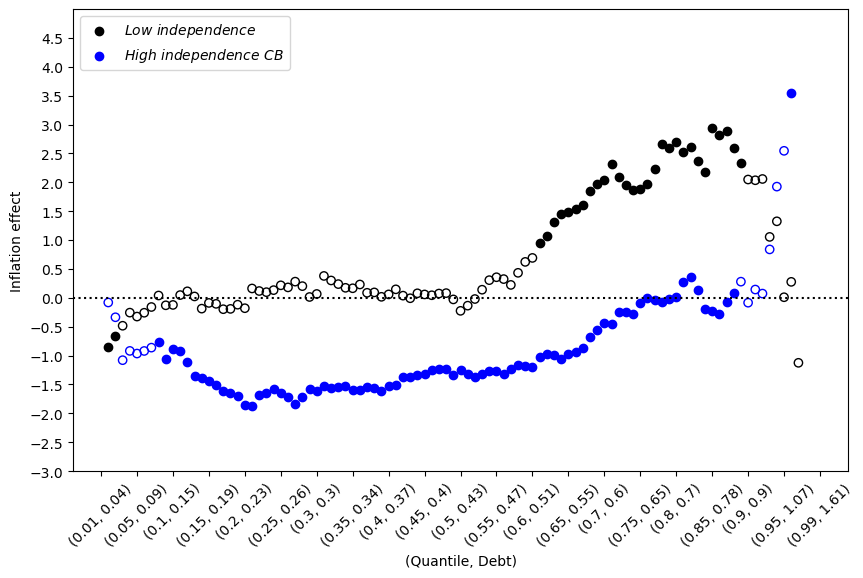

In [21]:
modelos = glob.glob(f'{results}/{INF}/{DEPENDIENTE}/*.xlsx')[2:3]

for i in modelos:
    result_df = pd.read_excel(i)
    ###################################################################################################################################################################
    plt.figure(figsize=(10, 6))
    
    #SCATTER PLOT
    bins = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 1]
    labels = [90, 70, 60, 40, 30, 20]


    result_df['pc'] = pd.cut(result_df['p-value'], bins=bins, labels=labels, include_lowest=True, right=False)
    result_df["significative"] = result_df["p-value"].apply(lambda x: 1 if x<0.1 else 0)
    significant = result_df[result_df['significative'] == 1]
    not_significant = result_df[result_df['significative'] == 0]
    # plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label=r'$\pi \times HD: p<0.1$')
    # plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', facecolors='none', edgecolors='black', label=r'$\pi \times HD: p \geq 0.1$')
    plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label=r'$Low\ independence\ $')
    plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', facecolors='none', edgecolors='black', label=None)


    result_df["significativeb"] = result_df["p-valueb"].apply(lambda x: 1 if x<0.1 else 0)
    significantb = result_df[result_df['significativeb'] == 1]
    not_significantb = result_df[result_df['significativeb'] == 0]
    plt.scatter(significantb['Quantile'], significantb['Slopeb'], marker='o', color='blue', label=r'$High\ independence\ CB\ $')
    plt.scatter(not_significantb['Quantile'], not_significantb['Slopeb'], marker='o', facecolors='none', edgecolors='blue', label=None)

    

    ############################################################################################
    # LINEAS DE THRESHOLD
    # Add a vertical line at x = threshold.Quantile with a label
    quantil_0 = result_df[result_df["Quantile_value"]>=0].Quantile.iloc[0]
    plt.axhline(y=0, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0
    # plt.axvline(x=quantil_0, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0

    ############################################################################################
    #LABELS/LEYENDAS
    plt.xlabel(f'(Quantile, Debt)')
    plt.ylabel(f'Inflation effect')


    ############################################################################################
    ymax = round(result_df["Slope"].max() + result_df["Slope"].std()/2,1)
    ymin = round(result_df["Slope"].min() - result_df["Slope"].std()/2,1)

    ymax, ymin = 5, -3
    # ymax, ymin = 0.007, -0.002
    plt.ylim(ymin, ymax)
    plt.yticks(np.arange(ymin, ymax, 0.5))  # Set custom y-axis ticks with 0.05 unit jumps

    qsticks= [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]
    df_tick = result_df[result_df["Quantile"].isin(qsticks)]
    custom_xticks = [(round(qs,2), round(qv,2)) for qs, qv in zip(df_tick['Quantile'], df_tick['Quantile_value'])]
    plt.xticks(np.arange(0, 1.05, 0.05), custom_xticks,rotation=45)  # Include rotation for better visibility

    plt.legend()
    plt.legend(scatterpoints=1, loc='upper left')

    k = i.replace(".xlsx", "_BC.svg")
    print(k)

    plt.savefig(k, dpi = 300, bbox_inches='tight')


    # plt.scatter(result_df['Quantile'], result_df['freq']) #PONLE ACÁ EL EJE Y DEL LADO DERECHO

    # plt.legend()
    # plt.legend(scatterpoints=1, loc='lower right')
    # # plt.grid(True)
    # plt.savefig(i.replace(".xlsx", ".jpeg"), dpi = 300, bbox_inches='tight')
    # plt.grid(False)
    # plt.show()

## Profundidad financiera

In [22]:
inftarg = pd.read_excel("INPUT/Inflation_Targeting.xlsx", sheet_name = "COMPILATION")
inftarg = inftarg[["ISO3","DATE", "absolute_target_deviation", "inside_range"]]
inftarg.columns = ["ISO3","DATE", "TD", "IR"]
dfit = pd.merge(dfr, inftarg, "left", ["ISO3", "DATE"])

inftargind = pd.read_excel("INPUT/Inflation_Targeting.xlsx", sheet_name = "INDEPENDENCY DATA")
inftargind = inftargind[["ISO3","DATE", 
                      "independence", "independence_ceo", "price_est_obj", "final_dec_monpol", "lending_government_restriction"]]

dfit = pd.merge(dfit, inftargind, "left", ["ISO3", "DATE"])

# inftarg.columns = ["ISO3","DATE", "TD", "IR"]

# "independence"
# "final_dec_monpol"

# IND = "final_dec_monpol"

dfit["PF1"] = dfit["PNFS_NFS"].apply(lambda x: 1 if x>=0.7 else 0)

dfit["PF2"] = dfit["FOR1_DB"].apply(lambda x: 1 if x>=0.24 else 0)



IND = "PF2"
INT = f"{IND}_PI"

dfit = dfit[dfit[IND].notna()]
dfit[INT] = dfit[IND]*dfit["PI"]

DEPENDIENTE   =  "DEBT_GDP" 
INDEPENDIENTE =  INT

os.makedirs(f'{results}/{INF}/{DEPENDIENTE}', exist_ok=True)

In [23]:
CONTROLES = ["0_NOCONTROL", "1_DEUCONTROL", "2_ALLCONTROL"]
# CONTROLES = ["1_DEUCONTROL"]
CONTROLES = ["2_ALLCONTROL"]


for CONTROL in CONTROLES:

    result_df = pd.DataFrame()
    rango_pct = np.arange(0.01, 1, 0.01)

    for i in tqdm(rango_pct):

        qv = dfit[DEPENDIENTE].quantile(i)
        qs = i

        if CONTROL == '0_NOCONTROL':
            
            formula = f'{DEPENDIENTE}  ~  PI + {IND} + {INT}'
        
        elif  CONTROL == '1_DEUCONTROL':
            formula = f'{DEPENDIENTE}  ~  PI + {IND} + {INT} + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1'
            
        elif  CONTROL == '2_ALLCONTROL':
            formula = f'{DEPENDIENTE}  ~  PI + {IND} + {INT} + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + WGI_GOV_IND + DEMOCRACY'
            
            
        model = smf.quantreg(formula, dfit)
        result = model.fit(q=qs)

        lower, upper = result.conf_int().loc[INDEPENDIENTE, 0], result.conf_int().loc[INDEPENDIENTE, 1]

        new_row_df = pd.DataFrame({
            'Quantile': [qs],
            'Quantile_value': [qv],
            'Slope': [result.params["PI"]],
            "p-value": [result.pvalues["PI"]],
            'Slopeb': [result.params["PI"]+result.params[INDEPENDIENTE]],
            "p-valueb": [result.pvalues[INDEPENDIENTE]],
            "R-squared": [result.prsquared]
        })

        # Usas pd.concat() para añadir la nueva fila al DataFrame existente:
        result_df = pd.concat([result_df, new_row_df], ignore_index=True)
        
    result_df["Quantile"] = round(result_df["Quantile"], 2)
    result_df.to_excel(f'{results}/{INF}/{DEPENDIENTE}/{CONTROL}.xlsx', index = False)

 16%|█▌        | 16/99 [00:01<00:07, 10.48it/s]c:\Users\USUARIO\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 25%|██▌       | 25/99 [00:02<00:08,  8.75it/s]c:\Users\USUARIO\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 35%|███▌      | 35/99 [00:03<00:06, 10.04it/s]c:\Users\USUARIO\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\USUARIO\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  

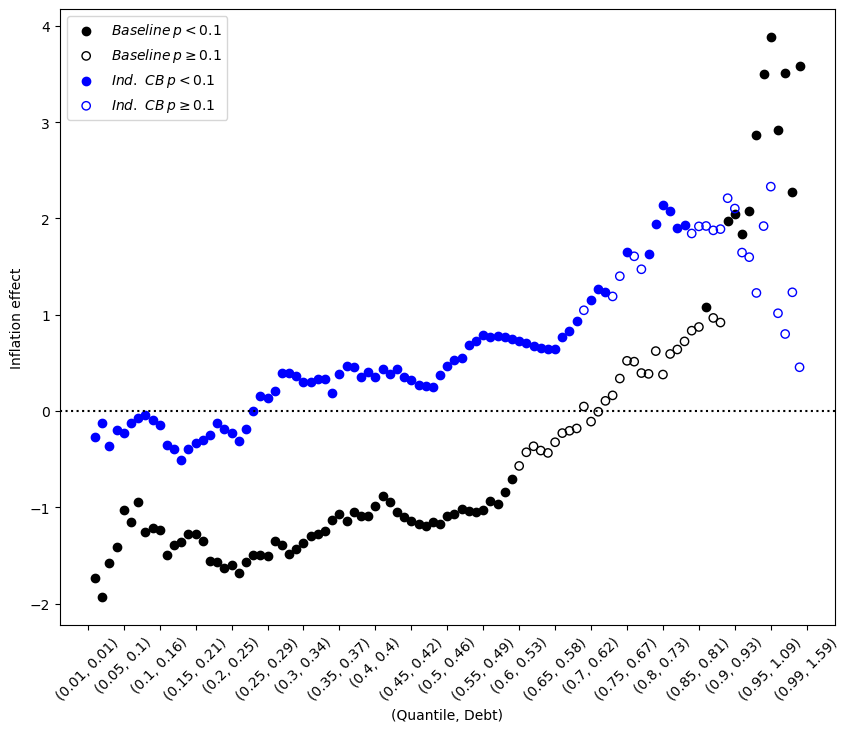

In [24]:
modelos = glob.glob(f'{results}/{INF}/{DEPENDIENTE}/*.xlsx')[2:3]

for i in modelos:
    result_df = pd.read_excel(i)
    ###################################################################################################################################################################
    plt.figure(figsize=(10, 8))
    
    #SCATTER PLOT
    bins = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 1]
    labels = [90, 70, 60, 40, 30, 20]


    result_df['pc'] = pd.cut(result_df['p-value'], bins=bins, labels=labels, include_lowest=True, right=False)
    result_df["significative"] = result_df["p-value"].apply(lambda x: 1 if x<0.1 else 0)
    significant = result_df[result_df['significative'] == 1]
    not_significant = result_df[result_df['significative'] == 0]
    # plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label=r'$\pi \times HD: p<0.1$')
    # plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', facecolors='none', edgecolors='black', label=r'$\pi \times HD: p \geq 0.1$')
    plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label=r'$Baseline\: p<0.1$')
    plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', facecolors='none', edgecolors='black', label=r'$Baseline\: p \geq 0.1$')


    result_df["significativeb"] = result_df["p-valueb"].apply(lambda x: 1 if x<0.1 else 0)
    significantb = result_df[result_df['significativeb'] == 1]
    not_significantb = result_df[result_df['significativeb'] == 0]
    plt.scatter(significantb['Quantile'], significantb['Slopeb'], marker='o', color='blue', label=r'$Ind.\ CB\: p<0.1$')
    plt.scatter(not_significantb['Quantile'], not_significantb['Slopeb'], marker='o', facecolors='none', edgecolors='blue', label=r'$Ind.\ CB\: p \geq 0.1$')

    

    ############################################################################################
    # LINEAS DE THRESHOLD
    # Add a vertical line at x = threshold.Quantile with a label
    quantil_0 = result_df[result_df["Quantile_value"]>=0].Quantile.iloc[0]
    plt.axhline(y=0, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0
    # plt.axvline(x=quantil_0, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0

    ############################################################################################
    #LABELS/LEYENDAS
    plt.xlabel(f'(Quantile, Debt)')
    plt.ylabel(f'Inflation effect')


    ############################################################################################
    ymax = round(result_df["Slope"].max() + result_df["Slope"].std()/2,1)
    ymin = round(result_df["Slope"].min() - result_df["Slope"].std()/2,1)

    # ymax, ymin = 5, -3
    # # ymax, ymin = 0.007, -0.002
    # plt.ylim(ymin, ymax)
    # plt.yticks(np.arange(ymin, ymax, 0.5))  # Set custom y-axis ticks with 0.05 unit jumps

    qsticks= [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]
    df_tick = result_df[result_df["Quantile"].isin(qsticks)]
    custom_xticks = [(round(qs,2), round(qv,2)) for qs, qv in zip(df_tick['Quantile'], df_tick['Quantile_value'])]
    plt.xticks(np.arange(0, 1.05, 0.05), custom_xticks,rotation=45)  # Include rotation for better visibility

    plt.legend()
    plt.legend(scatterpoints=1, loc='upper left')


    # plt.scatter(result_df['Quantile'], result_df['freq']) #PONLE ACÁ EL EJE Y DEL LADO DERECHO

    # plt.legend()
    # plt.legend(scatterpoints=1, loc='lower right')
    # # plt.grid(True)
    # plt.savefig(i.replace(".xlsx", ".jpeg"), dpi = 300, bbox_inches='tight')
    # plt.grid(False)
    # plt.show()

## Chanel: depreciación

### Paramétros

In [ ]:
DEPENDIENTE   =  "ER_DEP" 
INDEPENDIENTE =  "DH_PI"

os.makedirs(f'{results}/{INF}/{DEPENDIENTE}', exist_ok=True)

In [ ]:
dftc = dfr[dfr.ER_DEP!=0]
# dftc = dfr.copy()

### Estimación (tablas)

In [ ]:
# CONTROLES = ["0_NOCONTROL", "1_DEUCONTROL", "2_ALLCONTROL"]
# CONTROLES = ["0_NOCONTROL"]
CONTROLES = ["2_ALLCONTROL"]


for CONTROL in CONTROLES:

    result_df = pd.DataFrame()
    rango_pct = np.arange(0.01, 1, 0.01)

    for i in tqdm(rango_pct):

        qv = dftc[DEPENDIENTE].quantile(i)
        qs = i

        if CONTROL == '0_NOCONTROL':
            
            formula = f'{DEPENDIENTE}  ~  PI + DH + PI + DH_PI'
        
        elif  CONTROL == '1_DEUCONTROL':
            formula = f'{DEPENDIENTE}  ~  PI + DH + PI + DH_PI + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + WGI_GOV_IND + DEMOCRACY'
        
        elif  CONTROL == '2_ALLCONTROL':
            formula = f'{DEPENDIENTE}  ~  PI + DH + PI + DH_PI + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1'
            
        model = smf.quantreg(formula, dftc)
        result = model.fit(q=qs)

        lower, upper = result.conf_int().loc[INDEPENDIENTE, 0], result.conf_int().loc[INDEPENDIENTE, 1]

        new_row_df = pd.DataFrame({
            'Quantile': [qs],
            'Quantile_value': [qv],
            'Slope': [result.params["PI"]],
            "p-value": [result.pvalues["PI"]],
            'Slopeb': [result.params["PI"]+result.params[INDEPENDIENTE]],
            # 'Slope': [result.params[INDEPENDIENTE]],
            "p-valueb": [result.pvalues[INDEPENDIENTE]],
            "R-squared": [result.prsquared]
        })

        # Usas pd.concat() para añadir la nueva fila al DataFrame existente:
        result_df = pd.concat([result_df, new_row_df], ignore_index=True)
        
    result_df["Quantile"] = round(result_df["Quantile"], 2)
    result_df.to_excel(f'{results}/{INF}/{DEPENDIENTE}/{CONTROL}.xlsx', index = False)


  9%|▉         | 9/99 [00:01<00:15,  5.86it/s]c:\Users\War\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
100%|██████████| 99/99 [00:18<00:00,  5.35it/s]
<ipython-input-130-ed65f1e675c1>:46: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  result_df.to_excel(f'{results}/{INF}/{DEPENDIENTE}/{CONTROL}.xlsx', index = False)


### Gráficas

In [ ]:
modelos = glob.glob(f'{results}/{INF}/{DEPENDIENTE}/*.xlsx')

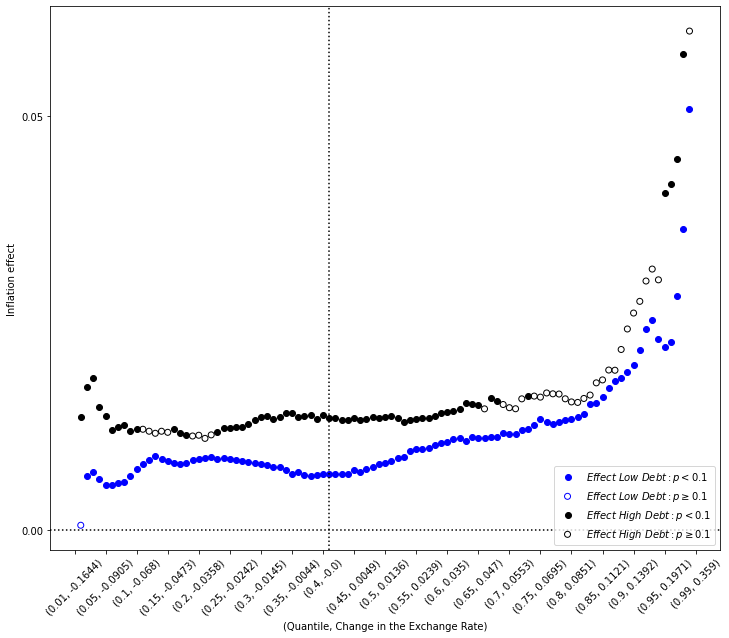

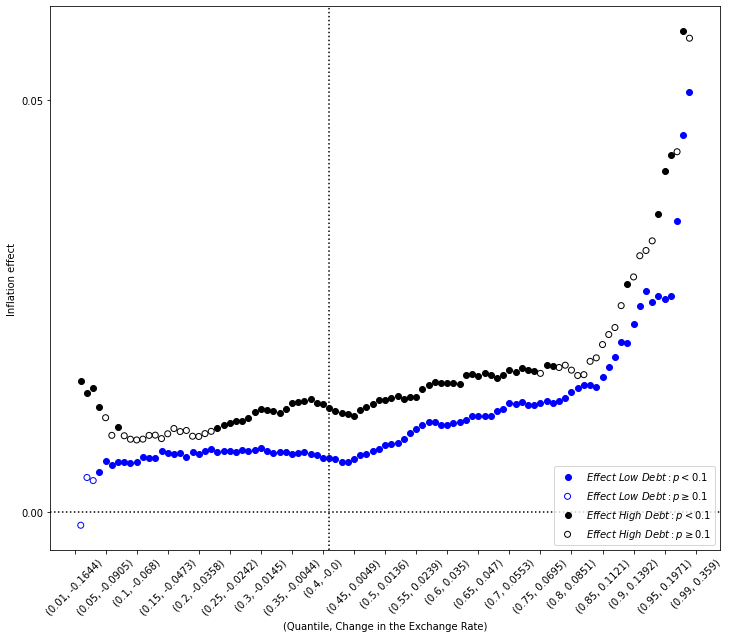

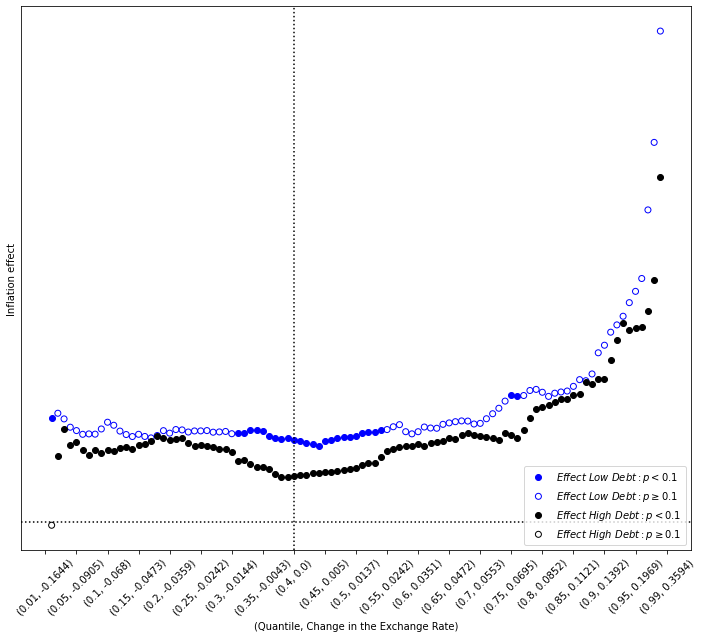

In [ ]:
for i in modelos:
    result_df = pd.read_excel(i)
    ###################################################################################################################################################################
    plt.figure(figsize=(12, 10))
    
    #SCATTER PLOT
    bins = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 1]
    labels = [90, 70, 60, 40, 30, 20]

    result_df["significativeb"] = result_df["p-valueb"].apply(lambda x: 1 if x<0.1 else 0)
    significantb = result_df[result_df['significativeb'] == 1]
    not_significantb = result_df[result_df['significativeb'] == 0]
    plt.scatter(significantb['Quantile'], significantb['Slopeb'], marker='o', color='blue', label=r'$Effect\ Low\ Debt: p<0.1$')
    plt.scatter(not_significantb['Quantile'], not_significantb['Slopeb'], marker='o', facecolors='none', edgecolors='blue', label=r'$Effect\ Low\ Debt: p \geq 0.1$')

    
    result_df['pc'] = pd.cut(result_df['p-value'], bins=bins, labels=labels, include_lowest=True, right=False)
    result_df["significative"] = result_df["p-value"].apply(lambda x: 1 if x<0.1 else 0)
    significant = result_df[result_df['significative'] == 1]
    not_significant = result_df[result_df['significative'] == 0]
    # plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label=r'$\pi \times HD: p<0.1$')
    # plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', facecolors='none', edgecolors='black', label=r'$\pi \times HD: p \geq 0.1$')
    plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label=r'$Effect\ High\ Debt: p<0.1$')
    plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', facecolors='none', edgecolors='black', label=r'$Effect\ High\ Debt: p \geq 0.1$')


    ############################################################################################
    # LINEAS DE THRESHOLD
    # Add a vertical line at x = threshold.Quantile with a label
    quantil_0 = result_df[result_df["Quantile_value"]>=0].Quantile.iloc[0]
    plt.axhline(y=0, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0
    plt.axvline(x=quantil_0, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0

    ############################################################################################
    #LABELS/LEYENDAS
    plt.xlabel(f'(Quantile, Change in the Exchange Rate)')
    plt.ylabel(f'Inflation effect')


    ############################################################################################
    ymax = round(result_df["Slope"].max() + result_df["Slope"].std()/2,1)
    ymin = round(result_df["Slope"].min() - result_df["Slope"].std()/2,1)

    # ymax, ymin = 0.2, -0.5
    # ymax, ymin = 0.007, -0.002
    # plt.ylim(ymin, ymax)
    plt.yticks(np.arange(ymin, ymax, 0.05))  # Set custom y-axis ticks with 0.05 unit jumps

    qsticks= [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]
    df_tick = result_df[result_df["Quantile"].isin(qsticks)]
    custom_xticks = [(round(qs,3), round(qv,4)) for qs, qv in zip(df_tick['Quantile'], df_tick['Quantile_value'])]
    plt.xticks(np.arange(0, 1.05, 0.05), custom_xticks,rotation=45)  # Include rotation for better visibility


    # plt.scatter(result_df['Quantile'], result_df['freq']) #PONLE ACÁ EL EJE Y DEL LADO DERECHO

    plt.legend()
    plt.legend(scatterpoints=1, loc='lower right')
    # plt.grid(True)
    plt.savefig(i.replace(".xlsx", ".jpeg"), dpi = 300, bbox_inches='tight')
    plt.grid(False)
    plt.show()

## Chanel: deuda pública sector no financiero

### Paramétros

In [25]:
DEPENDIENTE   =  "PNFS_NFS"
INDEPENDIENTE =  "DH_PI"
os.makedirs(f'{results}/{INF}/{DEPENDIENTE}', exist_ok=True)

In [26]:
dftc = dfr.copy()

### Estimación (tablas)

In [27]:
CONTROLES = ["0_NOCONTROL", "1_DEUCONTROL", "2_ALLCONTROL"]
# CONTROLES = ["0_NOCONTROL"]
CONTROLES = ["2_ALLCONTROL"]


for CONTROL in CONTROLES:

    result_df = pd.DataFrame()
    rango_pct = np.arange(0.01, 1, 0.01)

    for i in tqdm(rango_pct):

        qv = dftc[DEPENDIENTE].quantile(i)
        qs = i

        if CONTROL == '0_NOCONTROL':
            
            formula = f'{DEPENDIENTE}  ~  PI + DH +  + DH_PI'
        
        elif  CONTROL == '1_DEUCONTROL':
            formula = f'{DEPENDIENTE}   ~  PI + DH + + DH_PI + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + ER_DEP_l1 + ER_DEP_VOL_l1'
        
        elif  CONTROL == '2_ALLCONTROL':
            formula = f'{DEPENDIENTE}  ~  PI + DH + + DH_PI + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + + ER_DEP_l1 + ER_DEP_VOL_l1 + WGI_GOV_IND + DEMOCRACY'
            
        model = smf.quantreg(formula, dftc)
        result = model.fit(q=qs)

        lower, upper = result.conf_int().loc[INDEPENDIENTE, 0], result.conf_int().loc[INDEPENDIENTE, 1]

        new_row_df = pd.DataFrame({
            'Quantile': [qs],
            'Quantile_value': [qv],
            'Slope': [result.params["PI"]],
            "p-value": [result.pvalues["PI"]],
            'Slopeb': [result.params["PI"]+result.params[INDEPENDIENTE]],
            "p-valueb": [result.pvalues[INDEPENDIENTE]],
            "R-squared": [result.prsquared]
        })

        # Usas pd.concat() para añadir la nueva fila al DataFrame existente:
        result_df = pd.concat([result_df, new_row_df], ignore_index=True)
        
    result_df["Quantile"] = round(result_df["Quantile"], 2)
    result_df.to_excel(f'{results}/{INF}/{DEPENDIENTE}/{CONTROL}.xlsx', index = False)


  0%|          | 0/99 [00:00<?, ?it/s]c:\Users\USUARIO\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
  4%|▍         | 4/99 [00:00<00:07, 12.36it/s]c:\Users\USUARIO\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 15%|█▌        | 15/99 [00:01<00:05, 14.63it/s]c:\Users\USUARIO\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 19%|█▉        | 19/99 [00:01<00:05, 13.44it/s]c:\Users\USUARIO\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum nu

### Gráficas

In [28]:
modelos = glob.glob(f'{results}/{INF}/{DEPENDIENTE}/*.xlsx')

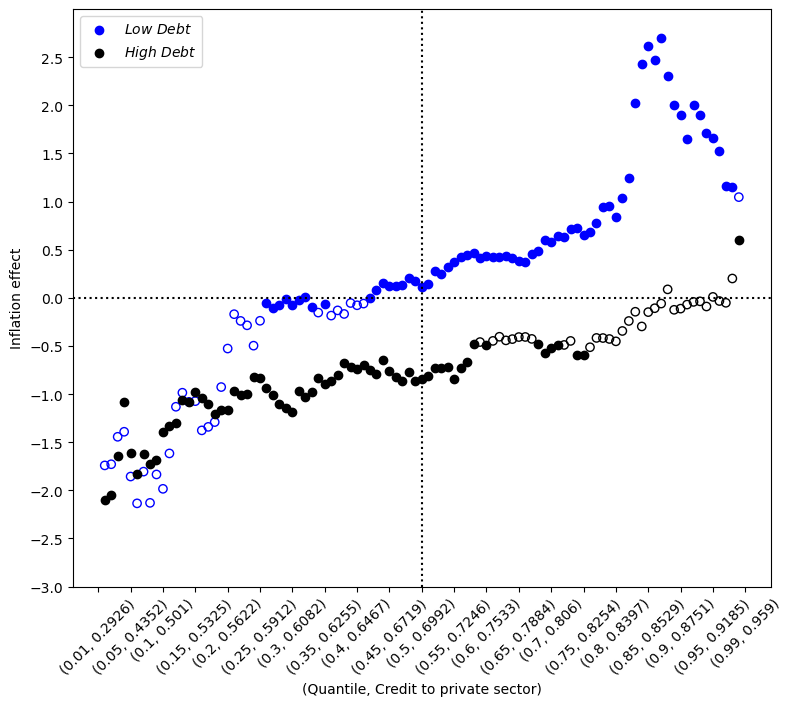

In [37]:
for i in modelos:
    result_df = pd.read_excel(i)
    ###################################################################################################################################################################
    plt.figure(figsize=(6*1.5, 5*1.5))
    
    #SCATTER PLOT
    bins = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 1]
    labels = [90, 70, 60, 40, 30, 20]

    result_df["significativeb"] = result_df["p-valueb"].apply(lambda x: 1 if x<0.1 else 0)
    significantb = result_df[result_df['significativeb'] == 1]
    not_significantb = result_df[result_df['significativeb'] == 0]
    plt.scatter(significantb['Quantile'], significantb['Slopeb'], marker='o', color='blue', label=r'$Low\ Debt $')
    plt.scatter(not_significantb['Quantile'], not_significantb['Slopeb'], marker='o', facecolors='none', edgecolors='blue', label=None)

    
    result_df['pc'] = pd.cut(result_df['p-value'], bins=bins, labels=labels, include_lowest=True, right=False)
    result_df["significative"] = result_df["p-value"].apply(lambda x: 1 if x<0.1 else 0)
    significant = result_df[result_df['significative'] == 1]
    not_significant = result_df[result_df['significative'] == 0]
    # plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label=r'$\pi \times HD: p<0.1$')
    # plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', facecolors='none', edgecolors='black', label=r'$\pi \times HD: p \geq 0.1$')
    plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label=r'$High\ Debt $')
    plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', facecolors='none', edgecolors='black', label=None)


    ############################################################################################
    # LINEAS DE THRESHOLD
    # Add a vertical line at x = threshold.Quantile with a label
    # quantil_0 = result_df[result_df["Quantile_value"]>=0].Quantile.iloc[0]
    plt.axhline(y=0, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0
    plt.axvline(x=0.5, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0

    ############################################################################################
    #LABELS/LEYENDAS
    plt.xlabel(f'(Quantile, Credit to private sector)')
    plt.ylabel(f'Inflation effect')


    ############################################################################################
    # ymax = round(result_df["Slope"].max() + result_df["Slope"].std()/2,1)
    # ymin = round(result_df["Slope"].min() - result_df["Slope"].std()/2,1)

    ymax, ymin = 3, -3
    # # ymax, ymin = 0.007, -0.002
    plt.ylim(ymin, ymax)
    plt.yticks(np.arange(ymin, ymax, 0.5))  # Set custom y-axis ticks with 0.05 unit jumps

    qsticks= [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]
    df_tick = result_df[result_df["Quantile"].isin(qsticks)]
    custom_xticks = [(round(qs,3), round(qv,4)) for qs, qv in zip(df_tick['Quantile'], df_tick['Quantile_value'])]
    plt.xticks(np.arange(0, 1.05, 0.05), custom_xticks,rotation=45)  # Include rotation for better visibility


    # plt.scatter(result_df['Quantile'], result_df['freq']) #PONLE ACÁ EL EJE Y DEL LADO DERECHO

    plt.legend()
    plt.legend(scatterpoints=1, loc='upper left')
    # plt.grid(True)
    plt.savefig(i.replace(".xlsx", ".svg"), dpi = 300, bbox_inches='tight')
    plt.grid(False)
    plt.show()

## Chanel: proporciónde bancos en manos de extranjeros

### Paramétros

In [38]:
DEPENDIENTE   =  "FOR1_DB"
INDEPENDIENTE =  "DH_PI"
os.makedirs(f'{results}/{INF}/{DEPENDIENTE}', exist_ok=True)

In [39]:
dftc = dfr.copy()

### Estimación (tablas)

In [40]:
# CONTROLES = ["0_NOCONTROL", "1_DEUCONTROL", "2_ALLCONTROL"]
# CONTROLES = ["0_NOCONTROL"]
CONTROLES = ["2_ALLCONTROL"]


for CONTROL in CONTROLES:

    result_df = pd.DataFrame()
    rango_pct = np.arange(0.01, 1, 0.01)

    for i in tqdm(rango_pct):

        qv = dftc[DEPENDIENTE].quantile(i)
        qs = i

        if CONTROL == '0_NOCONTROL':
            
            formula = f'{DEPENDIENTE}  ~  PI + DH + PI + DH_PI'
        
        elif  CONTROL == '1_DEUCONTROL':
            formula = f'{DEPENDIENTE}   ~  PI + DH + PI + DH_PI + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + ER_DEP_l1 + ER_DEP_VOL_l1'
        
        elif  CONTROL == '2_ALLCONTROL':
            formula = f'{DEPENDIENTE}  ~  PI + DH + PI + DH_PI + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + + ER_DEP_l1 + ER_DEP_VOL_l1 + WGI_GOV_IND + DEMOCRACY'
            
        model = smf.quantreg(formula, dftc)
        result = model.fit(q=qs)

        lower, upper = result.conf_int().loc[INDEPENDIENTE, 0], result.conf_int().loc[INDEPENDIENTE, 1]

        new_row_df = pd.DataFrame({
            'Quantile': [qs],
            'Quantile_value': [qv],
            'Slope': [result.params["PI"]],
            "p-value": [result.pvalues["PI"]],
            'Slopeb': [result.params["PI"]+result.params[INDEPENDIENTE]],
            "p-valueb": [result.pvalues[INDEPENDIENTE]],
            "R-squared": [result.prsquared]
        })

        # Usas pd.concat() para añadir la nueva fila al DataFrame existente:
        result_df = pd.concat([result_df, new_row_df], ignore_index=True)
        
    result_df["Quantile"] = round(result_df["Quantile"], 2)
    result_df.to_excel(f'{results}/{INF}/{DEPENDIENTE}/{CONTROL}.xlsx', index = False)


 25%|██▌       | 25/99 [00:02<00:12,  5.98it/s]c:\Users\USUARIO\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 30%|███       | 30/99 [00:03<00:10,  6.33it/s]c:\Users\USUARIO\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 39%|███▉      | 39/99 [00:04<00:06,  9.02it/s]c:\Users\USUARIO\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 46%|████▋     | 46/99 [00:05<00:05,  9.02it/s]c:\Users\USUARIO\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: 

### Gráficas

In [41]:
modelos = glob.glob(f'{results}/{INF}/{DEPENDIENTE}/*.xlsx')

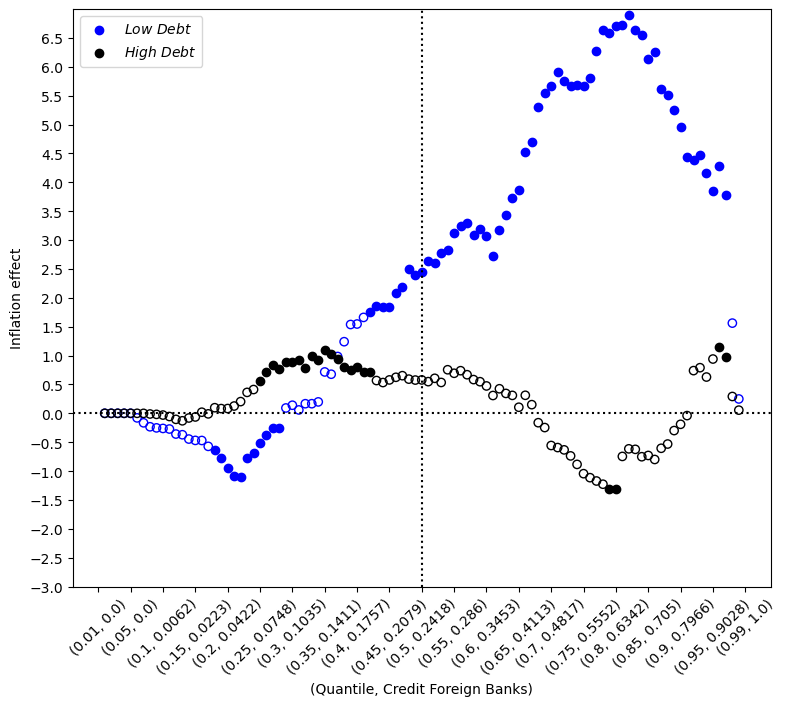

In [44]:
for i in modelos:
    result_df = pd.read_excel(i)
    ###################################################################################################################################################################
    plt.figure(figsize=(6*1.5, 5*1.5))
    
    #SCATTER PLOT
    bins = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 1]
    labels = [90, 70, 60, 40, 30, 20]

    result_df["significativeb"] = result_df["p-valueb"].apply(lambda x: 1 if x<0.1 else 0)
    significantb = result_df[result_df['significativeb'] == 1]
    not_significantb = result_df[result_df['significativeb'] == 0]
    plt.scatter(significantb['Quantile'], significantb['Slopeb'], marker='o', color='blue', label=r'$Low\ Debt $')
    plt.scatter(not_significantb['Quantile'], not_significantb['Slopeb'], marker='o', facecolors='none', edgecolors='blue', label=None)

    
    result_df['pc'] = pd.cut(result_df['p-value'], bins=bins, labels=labels, include_lowest=True, right=False)
    result_df["significative"] = result_df["p-value"].apply(lambda x: 1 if x<0.1 else 0)
    significant = result_df[result_df['significative'] == 1]
    not_significant = result_df[result_df['significative'] == 0]
    # plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label=r'$\pi \times HD: p<0.1$')
    # plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', facecolors='none', edgecolors='black', label=r'$\pi \times HD: p \geq 0.1$')
    plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label=r'$High\ Debt $')
    plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', facecolors='none', edgecolors='black', label=None)


    ############################################################################################
    # LINEAS DE THRESHOLD
    # Add a vertical line at x = threshold.Quantile with a label
    # quantil_0 = result_df[result_df["Quantile_value"]>=0].Quantile.iloc[0]
    plt.axhline(y=0, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0
    plt.axvline(x=0.5, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0

    ############################################################################################
    #LABELS/LEYENDAS
    plt.xlabel(f'(Quantile, Credit Foreign Banks)')
    plt.ylabel(f'Inflation effect')


    ############################################################################################
    # ymax = round(result_df["Slope"].max() + result_df["Slope"].std()/2,1)
    # ymin = round(result_df["Slope"].min() - result_df["Slope"].std()/2,1)

    ymax, ymin = 7, -3
    # # ymax, ymin = 0.007, -0.002
    plt.ylim(ymin, ymax)
    plt.yticks(np.arange(ymin, ymax, 0.5))  # Set custom y-axis ticks with 0.05 unit jumps

    qsticks= [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]
    df_tick = result_df[result_df["Quantile"].isin(qsticks)]
    custom_xticks = [(round(qs,3), round(qv,4)) for qs, qv in zip(df_tick['Quantile'], df_tick['Quantile_value'])]
    plt.xticks(np.arange(0, 1.05, 0.05), custom_xticks,rotation=45)  # Include rotation for better visibility


    # plt.scatter(result_df['Quantile'], result_df['freq']) #PONLE ACÁ EL EJE Y DEL LADO DERECHO

    plt.legend()
    plt.legend(scatterpoints=1, loc='upper left')
    # plt.grid(True)
    # plt.savefig(i.replace(".xlsx", ".svg"), dpi = 300, bbox_inches='tight')
    plt.grid(False)
    plt.show()

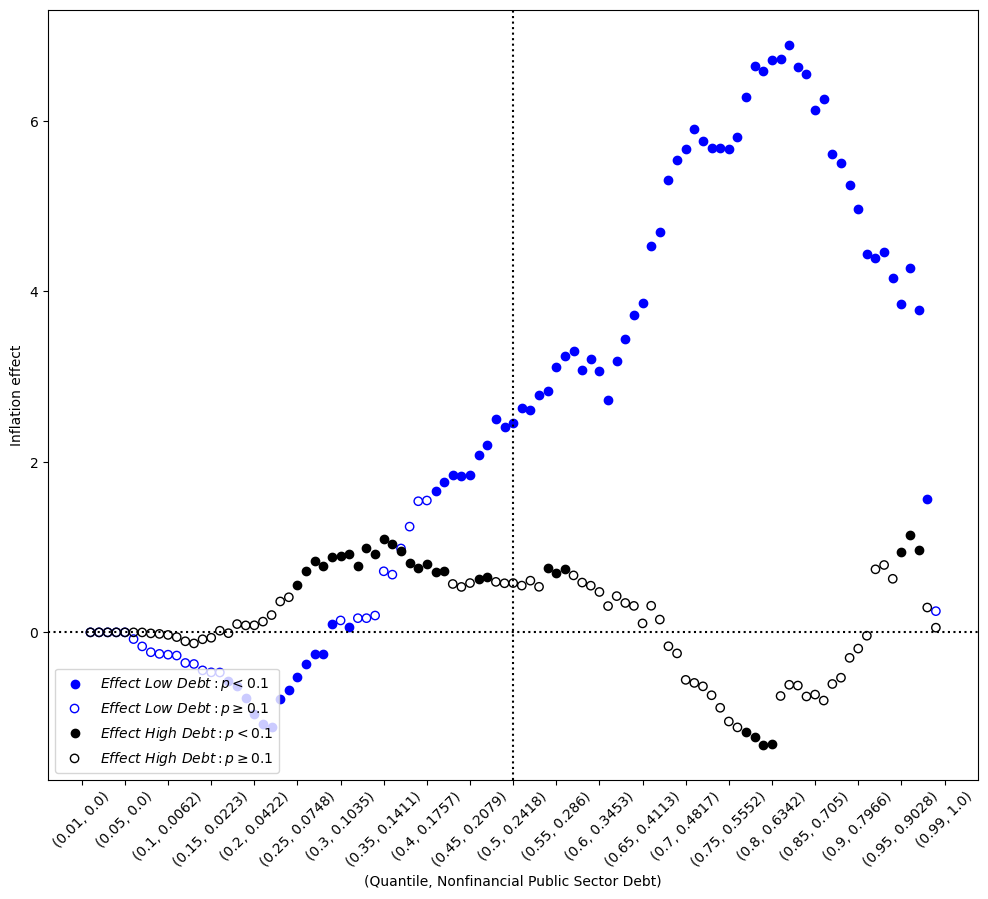

In [42]:
for i in modelos:
    result_df = pd.read_excel(i)
    ###################################################################################################################################################################
    plt.figure(figsize=(12, 10))
    
    #SCATTER PLOT
    bins = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 1]
    labels = [90, 70, 60, 40, 30, 20]

    result_df["significativeb"] = result_df["p-valueb"].apply(lambda x: 1 if x<0.15 else 0)
    significantb = result_df[result_df['significativeb'] == 1]
    not_significantb = result_df[result_df['significativeb'] == 0]
    plt.scatter(significantb['Quantile'], significantb['Slopeb'], marker='o', color='blue', label=r'$Effect\ Low\ Debt: p<0.1$')
    plt.scatter(not_significantb['Quantile'], not_significantb['Slopeb'], marker='o', facecolors='none', edgecolors='blue', label=r'$Effect\ Low\ Debt: p \geq 0.1$')

    
    result_df['pc'] = pd.cut(result_df['p-value'], bins=bins, labels=labels, include_lowest=True, right=False)
    result_df["significative"] = result_df["p-value"].apply(lambda x: 1 if x<0.15 else 0)
    significant = result_df[result_df['significative'] == 1]
    not_significant = result_df[result_df['significative'] == 0]
    # plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label=r'$\pi \times HD: p<0.1$')
    # plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', facecolors='none', edgecolors='black', label=r'$\pi \times HD: p \geq 0.1$')
    plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label=r'$Effect\ High\ Debt: p<0.1$')
    plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', facecolors='none', edgecolors='black', label=r'$Effect\ High\ Debt: p \geq 0.1$')


    ############################################################################################
    # LINEAS DE THRESHOLD
    # Add a vertical line at x = threshold.Quantile with a label
    # quantil_0 = result_df[result_df["Quantile_value"]>=0].Quantile.iloc[0]
    plt.axhline(y=0, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0
    plt.axvline(x=0.5, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0

    ############################################################################################
    #LABELS/LEYENDAS
    plt.xlabel(f'(Quantile, Nonfinancial Public Sector Debt)')
    plt.ylabel(f'Inflation effect')


    ############################################################################################
    # ymax = round(result_df["Slope"].max() + result_df["Slope"].std()/2,1)
    # ymin = round(result_df["Slope"].min() - result_df["Slope"].std()/2,1)

    # # ymax, ymin = 0.2, -0.5
    # # ymax, ymin = 0.007, -0.002
    # plt.ylim(ymin, ymax)
    # plt.yticks(np.arange(ymin, ymax, 0.05))  # Set custom y-axis ticks with 0.05 unit jumps

    qsticks= [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]
    df_tick = result_df[result_df["Quantile"].isin(qsticks)]
    custom_xticks = [(round(qs,3), round(qv,4)) for qs, qv in zip(df_tick['Quantile'], df_tick['Quantile_value'])]
    plt.xticks(np.arange(0, 1.05, 0.05), custom_xticks,rotation=45)  # Include rotation for better visibility


    # plt.scatter(result_df['Quantile'], result_df['freq']) #PONLE ACÁ EL EJE Y DEL LADO DERECHO

    plt.legend()
    plt.legend(scatterpoints=1, loc='lower left')
    # plt.grid(True)
    plt.savefig(i.replace(".xlsx", ".jpeg"), dpi = 300, bbox_inches='tight')
    plt.grid(False)
    plt.show()

## Chanel: crecimiento

### Paramétros

In [ ]:
DEPENDIENTE   =  "GDPG"
INDEPENDIENTE =  "DH_PI"
os.makedirs(f'{results}/{INF}/{DEPENDIENTE}', exist_ok=True)

In [ ]:
dftc = dfr.copy()

### Estimación (tablas)

In [ ]:
CONTROLES = ["0_NOCONTROL", "1_DEUCONTROL", "2_ALLCONTROL"]
# CONTROLES = ["0_NOCONTROL"]


for CONTROL in CONTROLES:

    result_df = pd.DataFrame()
    rango_pct = np.arange(0.01, 1, 0.01)

    for i in tqdm(rango_pct):

        qv = dftc[DEPENDIENTE].quantile(i)
        qs = i

        if CONTROL == '0_NOCONTROL':
            
            formula = f'GDPG  ~  PI + DH + PI + DH_PI'
        
        elif  CONTROL == '1_DEUCONTROL':
            formula = f'GDPG   ~  PI + DH + PI + DH_PI + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + ER_DEP_l1 + ER_DEP_VOL_l1'
        
        elif  CONTROL == '2_ALLCONTROL':
            formula = f'GDPG   ~  PI + DH + PI + DH_PI + DEBT_AFFORTABILITY_l1 + PRIM_BAL_GDP_l1 + + ER_DEP_l1 + ER_DEP_VOL_l1 + WGI_GOV_IND + DEMOCRACY'
            
        model = smf.quantreg(formula, dftc)
        result = model.fit(q=qs)

        lower, upper = result.conf_int().loc[INDEPENDIENTE, 0], result.conf_int().loc[INDEPENDIENTE, 1]

        new_row_df = pd.DataFrame({
            'Quantile': [qs],
            'Quantile_value': [qv],
            'Slopeb': [result.params["PI"]],
            "p-valueb": [result.pvalues["PI"]],
            'Slope': [result.params["PI"]+result.params[INDEPENDIENTE]],
            "p-value": [result.pvalues[INDEPENDIENTE]],
            "R-squared": [result.prsquared]
        })

        # Usas pd.concat() para añadir la nueva fila al DataFrame existente:
        result_df = pd.concat([result_df, new_row_df], ignore_index=True)
        
    result_df["Quantile"] = round(result_df["Quantile"], 2)
    result_df.to_excel(f'{results}/{INF}/{DEPENDIENTE}/{CONTROL}.xlsx', index = False)


  0%|          | 0/99 [00:00<?, ?it/s]


KeyError: 'GDPG'

### Gráficas

In [ ]:
modelos = glob.glob(f'{results}/{INF}/{DEPENDIENTE}/*.xlsx')

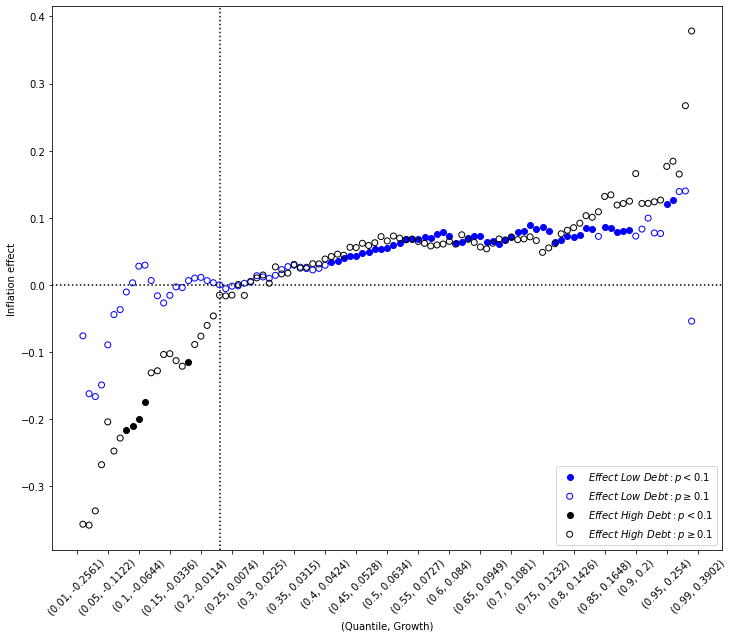

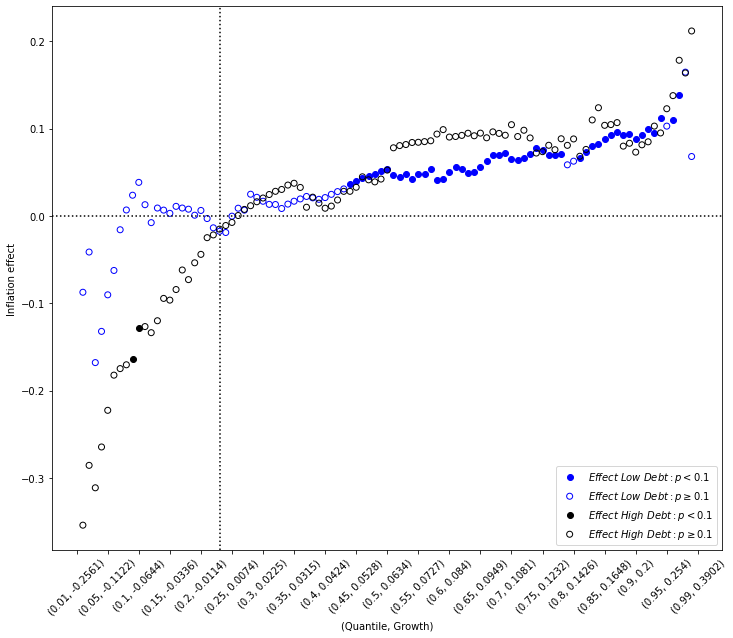

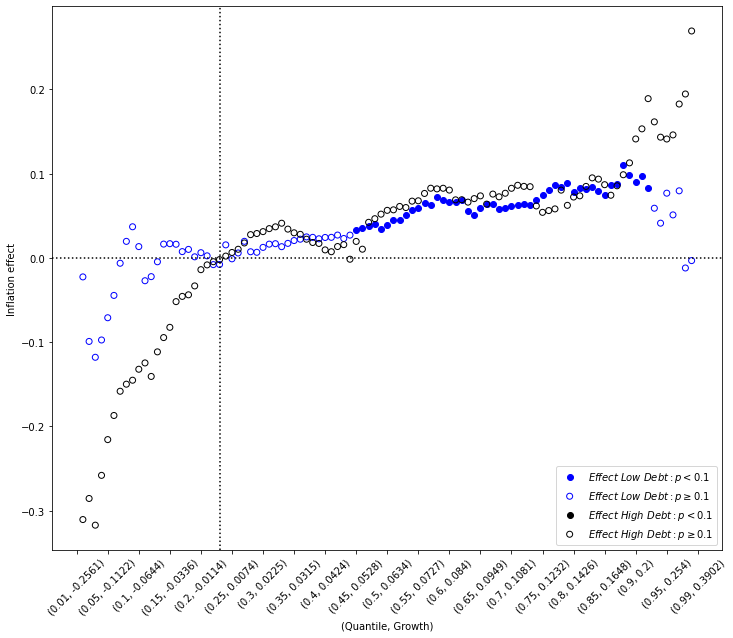

In [ ]:
for i in modelos:
    result_df = pd.read_excel(i)
    ###################################################################################################################################################################
    plt.figure(figsize=(12, 10))
    
    #SCATTER PLOT
    bins = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 1]
    labels = [90, 70, 60, 40, 30, 20]

    result_df["significativeb"] = result_df["p-valueb"].apply(lambda x: 1 if x<0.1 else 0)
    significantb = result_df[result_df['significativeb'] == 1]
    not_significantb = result_df[result_df['significativeb'] == 0]
    plt.scatter(significantb['Quantile'], significantb['Slopeb'], marker='o', color='blue', label=r'$Effect\ Low\ Debt: p<0.1$')
    plt.scatter(not_significantb['Quantile'], not_significantb['Slopeb'], marker='o', facecolors='none', edgecolors='blue', label=r'$Effect\ Low\ Debt: p \geq 0.1$')

    
    result_df['pc'] = pd.cut(result_df['p-value'], bins=bins, labels=labels, include_lowest=True, right=False)
    result_df["significative"] = result_df["p-value"].apply(lambda x: 1 if x<0.1 else 0)
    significant = result_df[result_df['significative'] == 1]
    not_significant = result_df[result_df['significative'] == 0]
    # plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label=r'$\pi \times HD: p<0.1$')
    # plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', facecolors='none', edgecolors='black', label=r'$\pi \times HD: p \geq 0.1$')
    plt.scatter(significant['Quantile'], significant['Slope'], marker='o', color='black', label=r'$Effect\ High\ Debt: p<0.1$')
    plt.scatter(not_significant['Quantile'], not_significant['Slope'], marker='o', facecolors='none', edgecolors='black', label=r'$Effect\ High\ Debt: p \geq 0.1$')


    ############################################################################################
    # LINEAS DE THRESHOLD
    # Add a vertical line at x = threshold.Quantile with a label
    quantil_0 = result_df[result_df["Quantile_value"]>=0].Quantile.iloc[0]
    plt.axhline(y=0, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0
    plt.axvline(x=quantil_0, color='black', linestyle='dotted')  # Add a horizontal black dotted line at Y = 0

    ############################################################################################
    #LABELS/LEYENDAS
    plt.xlabel(f'(Quantile, Growth)')
    plt.ylabel(f'Inflation effect')


    ############################################################################################
    # ymax = round(result_df["Slope"].max() + result_df["Slope"].std()/2,1)
    # ymin = round(result_df["Slope"].min() - result_df["Slope"].std()/2,1)

    # # ymax, ymin = 0.2, -0.5
    # # ymax, ymin = 0.007, -0.002
    # plt.ylim(ymin, ymax)
    # plt.yticks(np.arange(ymin, ymax, 0.05))  # Set custom y-axis ticks with 0.05 unit jumps

    qsticks= [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]
    df_tick = result_df[result_df["Quantile"].isin(qsticks)]
    custom_xticks = [(round(qs,3), round(qv,4)) for qs, qv in zip(df_tick['Quantile'], df_tick['Quantile_value'])]
    plt.xticks(np.arange(0, 1.05, 0.05), custom_xticks,rotation=45)  # Include rotation for better visibility


    # plt.scatter(result_df['Quantile'], result_df['freq']) #PONLE ACÁ EL EJE Y DEL LADO DERECHO

    plt.legend()
    plt.legend(scatterpoints=1, loc='lower right')
    # plt.grid(True)
    plt.savefig(i.replace(".xlsx", ".jpeg"), dpi = 300, bbox_inches='tight')
    plt.grid(False)
    plt.show()